Hva du faktisk kan analysere (konkrete forslag så du slipper å gjette)

Her er tre analyser som er enkle, ser avanserte ut og gir mening:

1. Hvor forskjellige er veinettverkene mellom to bydeler?

Indikatorer:

Gatetetthet (km/km²)

Node degree (hvor mange T-kryss vs 4-vei-kryss)

Betweenness centrality for veier

Closeness centrality for kryss

Hvorfor det funker:

Det er visuelt

Det er lett å forklare

Det gir et fint narrativ: «Bydel X har mer integrert veinett enn bydel Y»

2. Finn de viktigste veiene i en bydel (basert på betweenness)

Dette høres ekstremt smart ut på papiret og ser bra ut på et kart.

Vis f.eks:

Veier farget etter betweenness-verdi

Top 10 viktigste veier listet opp

Dette krever basically tre linjer med osmnx.

3. Hvor kronglete er veinettet?

Bruk:

Circuity = faktisk avstand / luftlinje

Dette er genialt hvis du sammenligner:

En «rutenett»-bydel (Frogner-ish)

En «organisk/forbannet labyrint»-bydel (Stovner-ish)

Resultatet blir automatisk interessant.

En veldig enkel prosjektidé for deg

Hvis du vil ha noe knallenkelt som likevel ser kult ut, så gjør følgende:

Tema:
Urbane indikatorer: sammenligning av gatenettverksstruktur mellom Stovner og Frogner.

Forskningsspørsmål:

Hvilken bydel har størst gatetetthet?

Hvilken bydel har mest integrert veinett?

Hvilke veier fungerer som hovedårer i hver bydel?

Hvor kronglete er veinettet i de to bydelene?

Datasett:

In [42]:
# importerer nødvendige bibliotek:

import contextily as ctx
import geopandas as gpd #fjern denne, for test kode


import osmnx as ox
from importlib import reload
import funksjoner
import matplotlib.pyplot as plt


In [3]:


# Her kan du oppdatere ordboken med områdene du ønsker å analysere
# Den følger (Nomatim) format Key = Navn, Value = bydel/område, by/kommune, land"

OMRÅDER = {
    "Stovner" : "Stovner, Oslo, Norway",
    "Frogner" : "Frogner, Oslo, Norway"
}

In [4]:
# Henter graph over områdene, med bilvei som standard nettverkstype:
grafer, nodes, edges = funksjoner.bygg_graf(OMRÅDER)

Henter data for Stovner, Oslo, Norway ...
Innehneting av data for Stovner, Oslo, Norway velykket!
Henter data for Frogner, Oslo, Norway ...
Innehneting av data for Frogner, Oslo, Norway velykket!


In [54]:
print(nodes["Frogner"].crs)

epsg:4326


In [6]:
# Henter ut polygonene for området for videre analyse:
# denne funksjonen returnerer EPSG:25833 som crs dersom ikke noe annet sendes inn i funksjonen

polygoner = funksjoner.sted_til_poly(OMRÅDER)


Nå har vi polygonet for stovner og frogner i en dictionary, samt tilhørende grafer.
Nå bruker vi street_length_total() fra omnx for å finne total veilengde.
Deretter deles dette på totalt areal for området. Resultat: veilengde per km^2

In [7]:
gatetetthet = funksjoner.beregn_gatetetthet(grafer, polygoner)

Funksjonen gir resultatet som en nøsted dictionary på formen:

gatetetthet = { 
    "Stovner": {
        "veilengde": ...,
        "polygon": ...,
        "areal": ...,
        "gatetetthet": ...
    },
    "Frogner": {
        "veilengde": ...,
        "polygon": ...,
        ...
    }
}


Nå har vi gatetetthet for de valgte områdene.
Resultatene kan visualiseres i et plot.

Gatetetthet (km/km²) for de to områdene:

In [118]:
reload(funksjoner)

<module 'funksjoner' from 'c:\\Users\\hakon\\OneDrive - Norwegian University of Life Sciences\\Documents\\NMBU\\GMGI221 - automatiseringGIS\\ovinger\\Prosjekt\\funksjoner.py'>

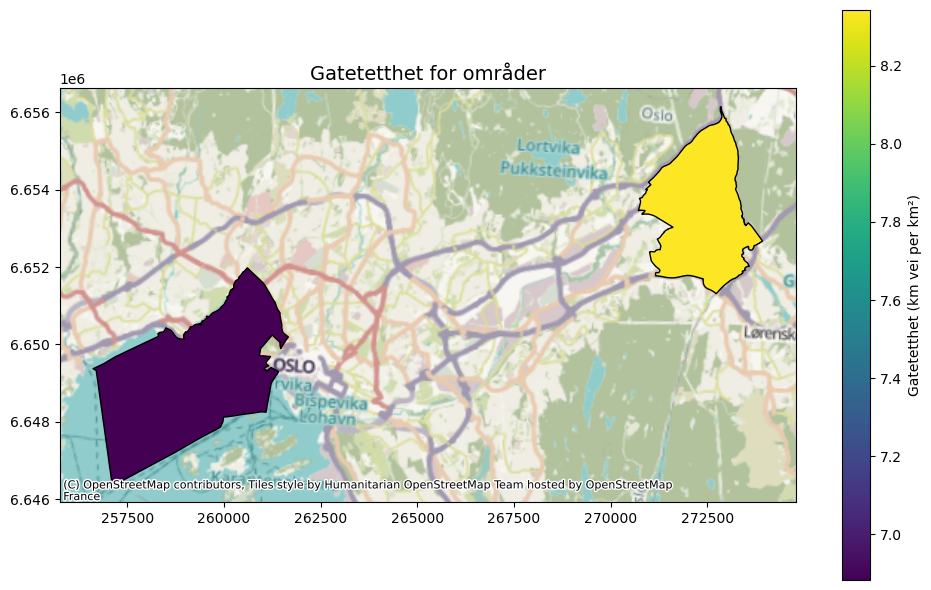

In [119]:
funksjoner.plot_gatetetthet(gatetetthet)

In [115]:
!pip install xyzservices